In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import optim
import torch.nn as nn
import pymysql


In [3]:
# 데이터 베이스 연결하기
conn = pymysql.connect(
    host="1.251.203.204",
    user="root",
    password="kdt5",
    db="Team4",
    charset="utf8",
    port=33065,
)

curs = conn.cursor()

# 검색 명령어 사용
sql = "SELECT en.text as en, de.text as de FROM language_en en join language_de de on en.id = de.id;"
curs.execute(sql)
result = curs.fetchall()
print("현재 테이블의 데이터수는 총 {}개 입니다.".format(len(result)))


현재 테이블의 데이터수는 총 31102개 입니다.


In [4]:
dataset = pd.read_sql(sql, conn)

# 데이터베이스 연결 종료
conn.close()

C:\Users\kdp\AppData\Local\Temp\ipykernel_1556\3849539243.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(sql, conn)


In [5]:
# 데이터의 전체 개수
total_samples = len(dataset)

# 검증 데이터의 개수 (전체 데이터의 10%)
validation_samples = int(0.1 * total_samples)

# 검증 데이터셋 선택
validation_data = dataset.iloc[:validation_samples]

# 나머지 데이터를 학습 데이터셋으로 사용
train_data = dataset.iloc[validation_samples:]

# 학습 데이터셋
train_iter = [
    (source_text, target_text)
    for source_text, target_text in zip(train_data["en"], train_data["de"])
]
# 검증 데이터셋
validation_iter = [
    (source_text, target_text)
    for source_text, target_text in zip(validation_data["en"], validation_data["de"])
]


In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


# 텍스트 이터레이터로부터 토큰을 생성하는 함수를 정의합니다.
def generate_tokens(text_iter, language):
    # 언어를 해당 언어의 인덱스에 매핑하는 사전을 생성합니다.
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    # 텍스트 이터레이터를 반복합니다.
    for text in text_iter:
        # 해당 언어에 기반하여 토큰화된 텍스트를 생성합니다.
        yield token_transform[language](text[language_index[language]])


# 소스 및 타겟 언어를 정의합니다.
SRC_LANGUAGE = "en"
TGT_LANGUAGE = "de"

# 특수 심볼에 대한 인덱스를 정의합니다.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# 특수 심볼을 정의합니다.
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

# 각 언어에 대한 토크나이제이션 변환을 정의합니다.
token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
}

# 어휘 변환 딕셔너리를 초기화합니다.
vocab_transform = {}

# 소스 및 타겟 언어에 대해 반복합니다.
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # 해당 언어 쌍의 훈련 데이터를 로드합니다.
    # 토큰화된 텍스트의 이터레이터로부터 어휘를 구축합니다.
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# 어휘에서 특수 토큰의 기본 인덱스를 설정합니다.
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

import pickle

# 소스 언어의 어휘 사전을 파일에 저장합니다.
with open("en_vocab_transform.pkl", "wb") as f:

    pickle.dump(vocab_transform[SRC_LANGUAGE], f)

# 타겟 언어의 어휘 사전을 파일에 저장합니다.
with open("de_vocab_transform.pkl", "wb") as f:
    pickle.dump(vocab_transform[TGT_LANGUAGE], f)


In [7]:
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 포지션 정보 계산
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # 사인(sin)과 코사인(cos) 함수를 사용하여 포지션 인코딩 값 계산
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # 입력 텐서와 포지셔널 인코딩 값을 더한 후 드롭아웃 적용
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)


In [8]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        # 임베딩 레이어 정의
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        # 입력 토큰에 대한 임베딩 값 반환
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


In [9]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,  # 인코더의 레이어 수
        num_decoder_layers,  # 디코더의 레이어 수
        emb_size,  # 임베딩 차원의 크기
        max_len,  # 입력 시퀀스의 최대 길이
        nhead,  # 멀티 헤드 어텐션의 헤드 수
        src_vocab_size,  # 소스 언어의 어휘 크기
        tgt_vocab_size,  # 타겟 언어의 어휘 크기
        dim_feedforward,  # 피드포워드 신경망의 은닉층 크기
        dropout=0.1,  # 드롭아웃 비율 (기본값은 0.1)
    ):
        super().__init__()
        # 소스와 타겟 토큰 임베딩 레이어 초기화
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        # 포지셔널 인코딩 레이어 초기화
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        # 트랜스포머 모델 초기화
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        # 출력 레이어 초기화
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        # 소스와 타겟 시퀀스에 포지셔널 인코딩 적용
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        # 트랜스포머 모델에 입력 및 마스크 전달하여 출력 계산
        outs = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )
        # 출력을 선형 레이어에 통과시켜 최종 출력 계산
        return self.generator(outs)

    def encode(self, src, src_mask):
        # 인코더를 통해 소스 시퀀스를 인코딩
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        # 디코더를 통해 타겟 시퀀스를 디코딩
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )


In [10]:
import math
import torch
from torch import nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )


In [11]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5)


c:\ProgramData\anaconda3\envs\TORCH_NLP38\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\ProgramData\anaconda3\envs\TORCH_NLP38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# 여러 전처리 함수를 연달아 적용하는 함수를 생성합니다.
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


# 입력 시퀀스에 대한 전처리 함수를 정의합니다.
def input_transform(token_ids):
    # 시작 토큰(BOS)과 끝 토큰(EOS)을 추가한 후 텐서를 합칩니다.
    return torch.cat(
        (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
    )


# 배치 데이터를 처리하는 함수를 정의합니다.
def collator(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        # 소스와 타겟 샘플에 대해 텍스트 전처리를 수행합니다.
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    # 패딩을 적용하여 모든 시퀀스의 길이를 맞춥니다.
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


# 언어별 텍스트 전처리 파이프라인을 설정합니다.
text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # 토큰화, 어휘 사전, 입력 전처리를 순차적으로 적용합니다.
    text_transform[language] = sequential_transforms(
        token_transform[language], vocab_transform[language], input_transform
    )

# 검증 데이터를 로드하고 배치 데이터로 변환합니다.

dataloader = DataLoader(validation_iter, batch_size=BATCH_SIZE, collate_fn=collator)
# 다음 배치 데이터를 가져옵니다.
source_tensor, target_tensor = next(iter(dataloader))


In [13]:
def generate_square_subsequent_mask(s):
    mask = (torch.triu(torch.ones((s, s), device=DEVICE)) == 1).transpose(0, 1)
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


target_input = target_tensor[:-1, :]
target_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input
)


In [14]:
def run(model, optimizer, criterion, split):
    if split == "train":
        model.train()
        dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collator)
    else:
        model.eval()
        dataloader = DataLoader(
            validation_iter, batch_size=BATCH_SIZE, collate_fn=collator
        )

    losses = 0
    for source_batch, target_batch in dataloader:
        source_batch = source_batch.to(DEVICE)
        target_batch = target_batch.to(DEVICE)

        target_input = target_batch[:-1, :]
        target_output = target_batch[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            source_batch, target_input
        )

        logits = model(
            src=source_batch,
            trg=target_input,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
        )

        optimizer.zero_grad()
        loss = criterion(
            logits.reshape(-1, logits.shape[-1]), target_output.reshape(-1)
        )
        if split == "train":
            loss.backward()
            optimizer.step()
        losses += loss.item()
    ##################### 희진이 돌리는 중 ##################
    return losses / len(list(dataloader))


min_loss = 10
train_, val_ = [], []
for epoch in range(1000):
    train_loss = run(model, optimizer, criterion, "train")
    train_.append(train_loss)
    val_loss = run(model, optimizer, criterion, "valid")
    scheduler.step(val_loss)
    val_.append(val_loss)
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), "en2de2.pt")


c:\ProgramData\anaconda3\envs\TORCH_NLP38\lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

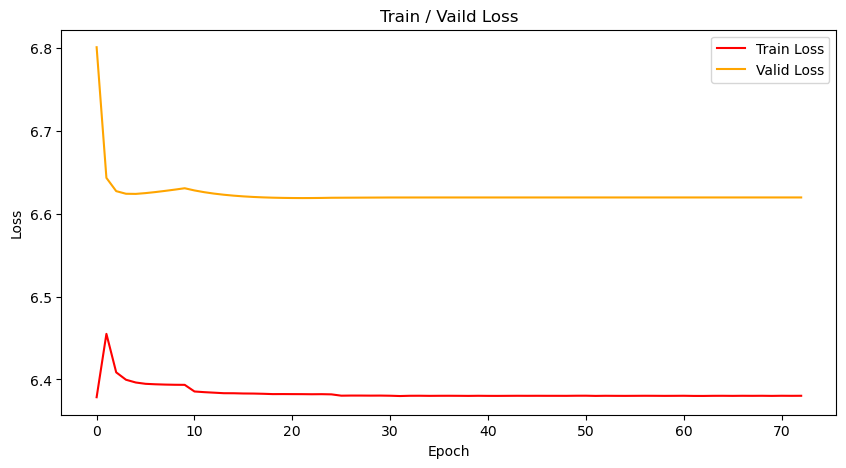

In [20]:
plt.figure(figsize=(10, 5))  # 희진이 돌리는 중 -----
plt.plot(train_, label="Train Loss", c="red")
plt.plot(val_, label="Valid Loss", c="orange")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel(
    "Loss",
)
plt.title("Train / Vaild Loss")
plt.show()


In [16]:
def translate(model, source_sentence):
    model.eval()
    src_tensor = torch.LongTensor([[vocab_transform[SRC_LANGUAGE](source_sentence)]])
    src_mask = model.transformer.generate_square_subsequent_mask(src_tensor.size(1)).to(DEVICE)
    tgt_tensor = torch.LongTensor([[BOS_IDX]]).to(DEVICE)
    with torch.no_grad():
        output = greedy_decode(model, src_tensor, src_mask, max_len=MAX_LENGTH, start_symbol=TGT_PAD_IDX)
    output = output[1:].flatten()
    translation = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(output.cpu().numpy()))
    return " ".join(translation)

In [18]:
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
    source_tensor = source_tensor.to(DEVICE)
    source_mask = source_mask.to(DEVICE)

    memory = model.encode(source_tensor, source_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        target_mask = generate_square_subsequent_mask(ys.size(0))
        target_mask = target_mask.type(torch.bool).to(DEVICE)

        out = model.decode(ys, memory, target_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word)], dim=0
        )
        if next_word == EOS_IDX:
            break
    return ys
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)
model.load_state_dict(torch.load("en2de.pt", map_location=DEVICE))
def translate(model, source_sentence):
    model.eval()
    source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1, 1)
    num_tokens = source_tensor.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, source_tensor, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    output = vocab_transform[TGT_LANGUAGE].lookup_tokens(
        list(tgt_tokens.cpu().numpy())
    )[1:-1]
    return " ".join(output)


output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Und die Könige der Erde, die Vergewaltigung begangen haben und mit ihr lebhaft gelebt haben, werden über sie weinen und für sie weinen, wenn sie den Rauch ihres Brandes sehen,")
print(output_oov)
print(output)


, , , , , , , , , , , , , ,
, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,


In [19]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import numpy as np

# Define the model architecture
class Seq2SeqTransformer(torch.nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, max_len, nhead,
                 src_vocab_size, tgt_vocab_size, dim_feedforward=512):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = torch.nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward
        )
        self.generator = torch.nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = torch.nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = torch.nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, max_len=max_len)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        memory = self.transformer.encoder(src_emb, src_mask, src_key_padding_mask=src_padding_mask)
        outs = self.transformer.decoder(tgt_emb, memory, tgt_mask, memory_mask=None,
                                        tgt_key_padding_mask=tgt_padding_mask,
                                        memory_key_padding_mask=memory_key_padding_mask)
        return self.generator(outs)


class PositionalEncoding(torch.nn.Module):
    def __init__(self, emb_size, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))
        pe = torch.zeros(max_len, emb_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Define the vocabulary
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

train_iter = [
    (train_data[i][0], train_data[i][1]) for i in range(len(train_data))
]

vocab_transform[SRC_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_iter, language=SRC_LANGUAGE))
vocab_transform[TGT_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_iter, language=TGT_LANGUAGE))

# Define the translation function
def translate(model, source_sentence):
    model.eval()
    src_tensor = torch.LongTensor([[vocab_transform[SRC_LANGUAGE](source_sentence)]])
    src_mask = model.transformer.generate_square_subsequent_mask(src_tensor.size(1)).to(DEVICE)
    tgt_tensor = torch.LongTensor([[BOS_IDX]]).to(DEVICE)
    with torch.no_grad():
        output = greedy_decode(model, src_tensor, src_mask, max_len=MAX_LENGTH, start_symbol=TGT_PAD_IDX)
    output = output[1:].flatten()
    translation = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(output.cpu().numpy()))
    return " ".join(translation)


# Load the model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)
model.load_state_dict(torch.load("en2de.pt", map_location=DEVICE))

# Perform translation
output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Und die Könige der Erde, die Vergewaltigung begangen haben und mit ihr lebhaft gelebt haben, werden über sie weinen und für sie weinen, wenn sie den Rauch ihres Brandes sehen,")
print(output_oov)
print(output)


KeyError: 0